In [0]:
#R: Comments beginning with "R:" are added by me for the purpose of the assignment.
#R: Brings both the train and test data sets into our local folder for use.
# download data (-q is the quiet mode)
! wget -q https://www.dropbox.com/s/lhb1awpi769bfdr/test.csv?dl=1 -O test.csv
! wget -q https://www.dropbox.com/s/gudb5eunj700s7j/train.csv?dl=1 -O train.csv

In [0]:
import pandas as pd

#Load in the entirety of the training dataset.
Xy_train = pd.read_csv('train.csv', engine='python')

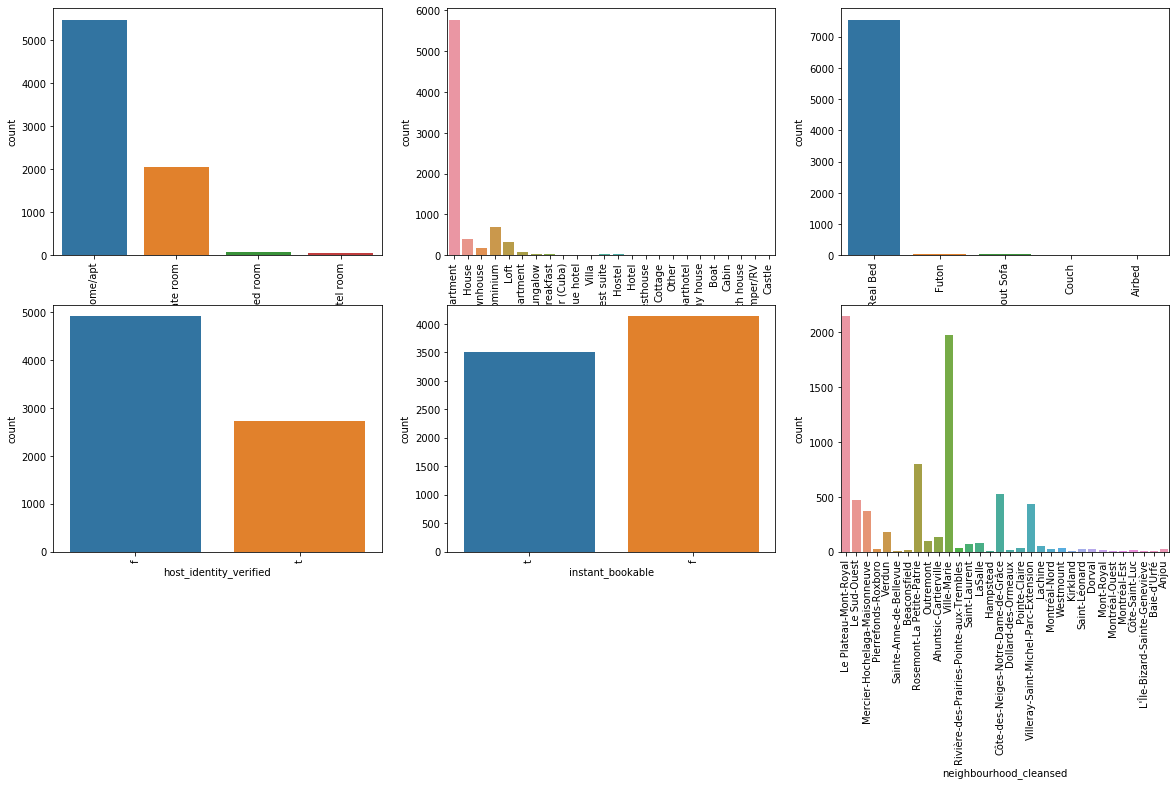

In [0]:
import seaborn as sns
import matplotlib as plt
from matplotlib.pyplot import subplots

#As the correlation heat map was not highly informative in my 1st script, I was motivated to try a new way of visualizing the features which
#I deemed would be worthwhile to train on. As categorical features didn't appear in the heat map I began with those.
catFeats = ['room_type','property_type','bed_type','host_identity_verified','instant_bookable','neighbourhood_cleansed']
fig, ax = subplots(2, 3, figsize=(20, 10))
for variable, subplot in zip(catFeats,ax.flatten()):
  sns.countplot(Xy_train[variable],ax=subplot)
  for label in subplot.get_xticklabels():
        label.set_rotation(90)


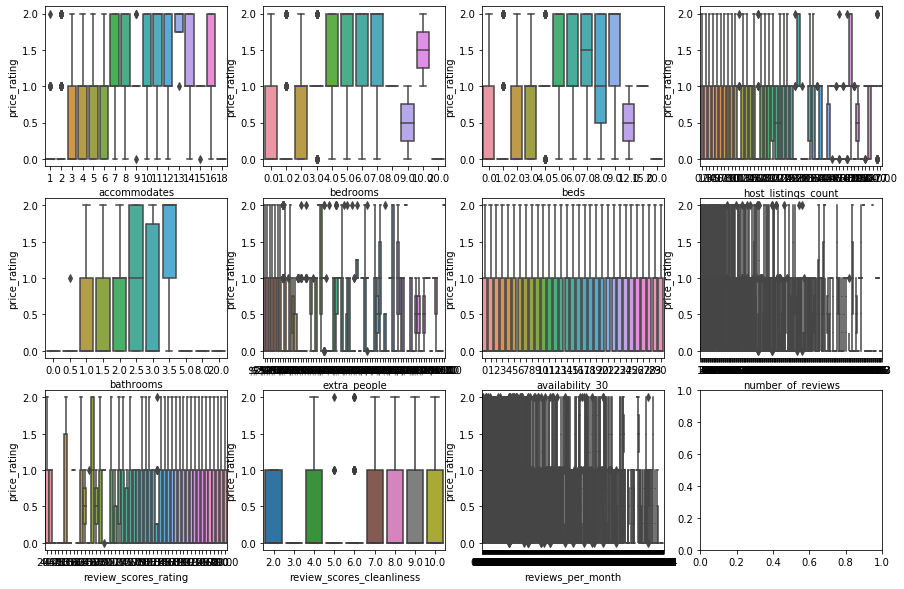

In [0]:
#Use boxplots to get an idea of how the price_rating target attribute depends on different
#numerical attributes.
numFeats = ['accommodates','bedrooms','beds','host_listings_count','bathrooms','extra_people',
            'availability_30','number_of_reviews','review_scores_rating','review_scores_cleanliness',
            'reviews_per_month']

fig, ax = subplots(3, 4, figsize=(15, 10))
for var, subplot in zip(numFeats, ax.flatten()):
    sns.boxplot(x=Xy_train[var], y = Xy_train['price_rating'], ax=subplot)

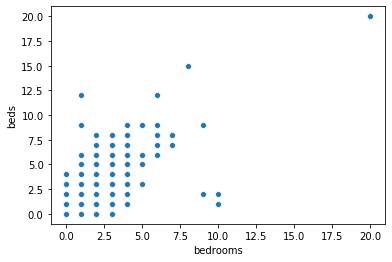

In [0]:
#Between two attributes there may exist outliers that don't make sense in the context of the problem.
#Two attributes where such a case may exist are bedrooms & beds...
sns.scatterplot(x=Xy_train['bedrooms'],y=Xy_train['beds'])

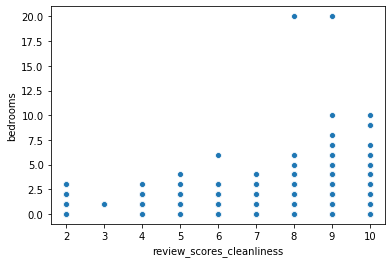

In [0]:
#There may exist attributes with counter intuitive relationships too.
sns.scatterplot(x=Xy_train['review_scores_cleanliness'],y=Xy_train['bedrooms'])

In [0]:
#Drops the small cluster of outliers identified in the bed & bedrooms scatterplot
Xy_train = Xy_train.drop(Xy_train[(Xy_train.beds < 5) & (Xy_train.bedrooms > 7.5)].index)

#Transforms the extra_people attribute to a numeric feature by removing the '$'.
Xy_train['extra_people'] = Xy_train['extra_people'].str.replace('$','')
Xy_train['extra_people'] = Xy_train['extra_people'].astype(float)

#Partition the training dataset and load in the testing dataset.
X_train = Xy_train.drop(columns=['price_rating'])
y_train = Xy_train[['price_rating']]
X_test = pd.read_csv('test.csv', engine='python')
#Process the extra_people feature in the test set the same way as in the training set.
X_test['extra_people'] = X_test['extra_people'].str.replace('$','')
X_test['extra_people'] = X_test['extra_people'].astype(float)
testing_ids = X_test.Id


In [0]:
# model training and tuning
#R: Import numerous libraries used for data manipulation, analysis and to build
#   build machine learning models capable of best predicting the price_rating 
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier

np.random.seed(0)

#Define what numeric and categorical features we would like to train the model with
numeric_features = ['accommodates','bedrooms','extra_people','bathrooms']
categorical_features = ['room_type','property_type','instant_bookable','neighbourhood_cleansed']

#Define a transformer for the numeric and categorical features.
numeric_transformer = Pipeline(steps = [
                      ('imputer', KNNImputer(n_neighbors = 3)),
                      ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps = [
                          ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                          ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#Define a typical preprocessor variable composed of the different transformers.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#Define the final pipeline variable. Indicates the model to be used is a Multilayer Perceptron for classification with a lbfgs solver.
classif = Pipeline(steps = [
                            ('preprocessor', preprocessor),
                            ('classifier', MLPClassifier(
                                solver = 'lbfgs'
                            ))
])

#Eliminate unused attributes from our training and testing sets.
X_train = X_train[[*numeric_features, *categorical_features]]
X_test = X_test[[*numeric_features, *categorical_features]]

#Set up the hyperparameter grid to be searched over.
#Final results are (Hidden Layer size = [6] / Alpha = 1e-6 / Activation = 'logistic / Max Fun = 125 000)
param_grid = {
    'classifier__hidden_layer_sizes': [[6],[20,6],[6,6,6,6],[6,3,6]],
    'classifier__alpha': [1e-6,1e-5,1e-4],
    'classifier__activation': ['logistic'],
    'classifier__max_fun': [25000,50000,100000,125000]
    'preprocessor__num__imputer__n_neighbours': = [2,4,5]
}

#Search all combinations of hyperparameters to find which scores the best.
grid_search = GridSearchCV(
    classif, param_grid, cv=5, verbose=3, n_jobs=3, scoring='accuracy')
#Fit a model with the selected hyperparameter combination.
grid_search.fit(X_train, y_train)

#R: Prints the best score acheived from our hyperparameter search.
print('best score {}'.format(grid_search.best_score_))
print(grid_search.best_params_)

In [0]:
# Prediction & generating the submission file
#Predicts the price_rating for all the test records. Creates a csv file with the
#test records respective Id and its predicted price_rating. 
y_pred = grid_search.predict(X_test)
pd.DataFrame(
    {'Id': testing_ids, 'price_rating':y_pred}).to_csv('a1submission4.csv', index=False)